In [2]:
from matplotlib.rcsetup import cycler
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.container import BarContainer
from matplotlib.ticker import PercentFormatter

plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "axes.prop_cycle": cycler(
            color=["xkcd:kelly green", "xkcd:orange", "xkcd:bright blue"]
        ),
    }
)

In [3]:
from pathlib import Path
from pandas._typing import AstypeArg

DATASET_DIR = Path("./datasets")

IMR_TYPES = ["Medical Necessity", "Experimental"]
PRIORITIES = ["Standard", "Expedited"]
OUTCOMES = ["Insurer Denial Overturned", "Insurer Denial Upheld", "Insured Withdrew"]

dtypes: dict[str, AstypeArg] = {
    "reference_number": "string",
    "year": "Int64",
    "imr_type": pd.CategoricalDtype(IMR_TYPES, ordered=True),
    "priority": pd.CategoricalDtype(PRIORITIES, ordered=True),
    "diagnosis": "category",
    "diagnosis_subcategory": "category",
    "treatment": "category",
    "treatment_subcategory": "category",
    "outcome": pd.CategoricalDtype(OUTCOMES, ordered=True),
    "age": "Int64",
    "gender": "category",
    "statutory_criteria": "object",
    "primary_language": "category",
    "race": "object",
    "imro_review_period": "Int64",
    "determination_period": "Int64",
}

df: pd.DataFrame = pd.read_csv(
    DATASET_DIR / "./imr_report.csv",
    sep=",",
    header=0,
    names=[*dtypes],
    index_col="reference_number",
    converters={
        "primary_language": lambda x: (
            pd.NA
            if str.casefold(x)
            in {
                "-",
                "decline to state",
                "dts",
                "other",
                "prefer not to disclo",
                "unknown",
            }
            else x
        ),
    },
    na_values={
        **dict.fromkeys(["age", "gender", "statutory_criteria"], "-"),
        "diagnosis_subcategory": ["Unspecified", "unspecified", "Not Applicable"],
        "treatment": "Not Applicable",
        "race": ["-", "Decline to state"],
        "imro_review_period": " days",
    },
    encoding="cp1252",  # https://en.wikipedia.org/wiki/Windows-1252
).set_flags(allows_duplicate_labels=False)

df.index = df.index.str.strip()
df = df.assign(
    statutory_criteria=tuple(df.statutory_criteria.str.split("\\n")),
    race=tuple(df.race.str.split(", ")),
    imro_review_period=df.imro_review_period.str.extract(r"(\d+) days"),
    determination_period=df.determination_period.str.extract(r"(\d+) days"),
)

df = df.astype({k: v for k, v in dtypes.items() if k != df.index.name})

print(df.head().to_string(na_rep="N/A"))
print()
print(f"NA values: \n{df.isna().sum().loc[lambda x: x > 0].sort_values(ascending=False).to_string()}")

                  year           imr_type   priority            diagnosis                diagnosis_subcategory                     treatment              treatment_subcategory                    outcome  age  gender                                                                           statutory_criteria primary_language     race  imro_review_period  determination_period
reference_number                                                                                                                                                                                                                                                                                                                                                                        
24-7980           2024  Medical Necessity  Expedited               Cancer                      Prostate cancer              Cancer Treatment  High Intensity Focused Ultrasound  Insurer Denial Overturned   63    Male  [Peer-reviewed scientific and

# Introduction


There are 4,972 datapoints in the dataset from years 2011 to 2024.

The dataset has 15 columns: year, imr_type, priority, diagnosis, diagnosis_subcategory, treatment, treatment_subcategory, outcome, age, gender, statutory_criteria, primary_language, race, imro_review_period, determination_period.

The 'outcome' column has 3 possible values: 'Insurer Denial Overturned', 'Insurer Denial Upheld' and 'Insured Withdrew'. 50.2% of cases end with outcome 'Insurer Denial Overturned', 49.0% end with 'Insurer Denial Upheld' and 0.9% end with 'Insured Withdrew'.


Outcome
Insurer Denial Overturned    2494
Insurer Denial Upheld        2435
Insured Withdrew               43


<Axes: title={'center': 'Outcome of IMR Requests'}>

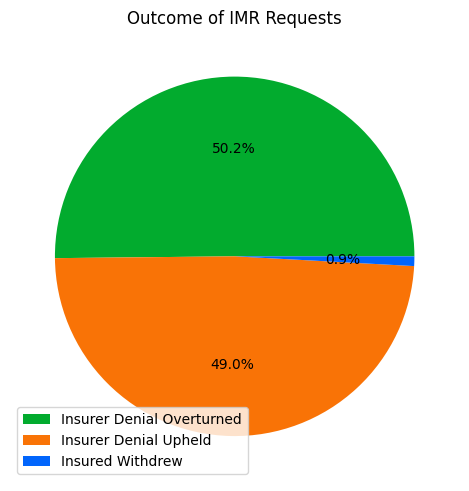

In [4]:
print(df.outcome.rename("Outcome").value_counts().to_string())

df.outcome.value_counts().plot(
    kind="pie",
    title="Outcome of IMR Requests",
    legend=True,
    ylabel="",
    autopct="%1.1f%%",
    labeldistance=None,
    normalize=True,
)

# Year


In general, you’ll notice a decreasing pattern in the number of cases reviewed in the IMR program, especially after 2020. On average, IMR saw 438 cases per year during 2011-2019 compared to 221 cases between 2020-2023.


      Insurer Denial Overturned  Insurer Denial Upheld  Insured Withdrew  Total
2011                        137                    243                 4    384
2012                        198                    267                 7    472
2013                        240                    241                 7    488
2014                        227                    220                 8    455
2015                        252                    217                 4    473
2016                        219                    225                 9    453
2017                        196                    240                 4    440
2018                        184                    216                 0    400
2019                        199                    176                 0    375
2020                        175                     99                 0    274
2021                        121                     71                 0    192
2022                        118         

/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_57653/1247321715.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcomes_by_year_df = df.groupby(["year", "outcome"]).size().unstack()


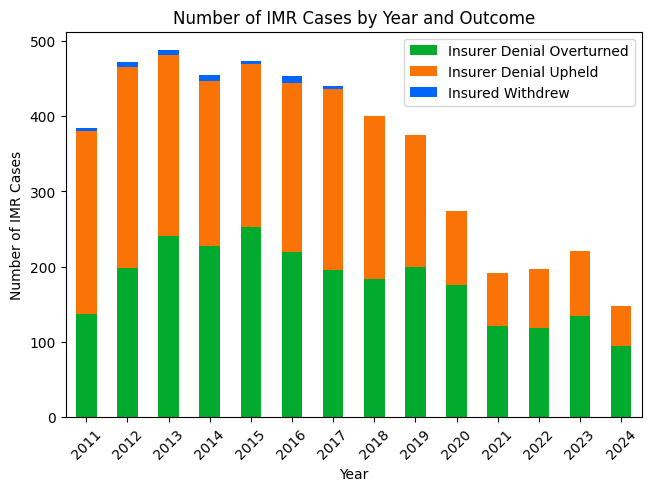

In [6]:
outcomes_by_year_df = df.groupby(["year", "outcome"]).size().unstack()

ax = outcomes_by_year_df.rename_axis(None, axis=1).plot.bar(
    title="Number of IMR Cases by Year and Outcome",
    xlabel="Year",
    ylabel="Number of IMR Cases",
    rot=45,
    stacked=True,
)

outcomes_by_year_df["Total"] = outcomes_by_year_df.sum(axis=1)

print(outcomes_by_year_df.to_string(index_names=False))
print()

YEAR_RANGES = [[2011, 2019], [2020, 2023]]
print(
    pd.Series(
        dict(
            [
                (f"{l}-{r}", df.loc[df.year.between(l, r)].year.value_counts().mean())
                for [l, r] in YEAR_RANGES
            ]
        ),
        name=f"Average Cases per Year ({', '.join(map(lambda x : '-'.join(map(str,x)), YEAR_RANGES))})",
    ).to_string(float_format="{:.1f}".format, name=True)
)

However, the percentage of insurer denials being overturned has also increased dramatically, from 36% in 2011 to 64% in 2024. Furthermore, there has been 0 cases with outcome 'Insured Withdrew' after 2018.


/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_54455/1083425212.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "outcome"])


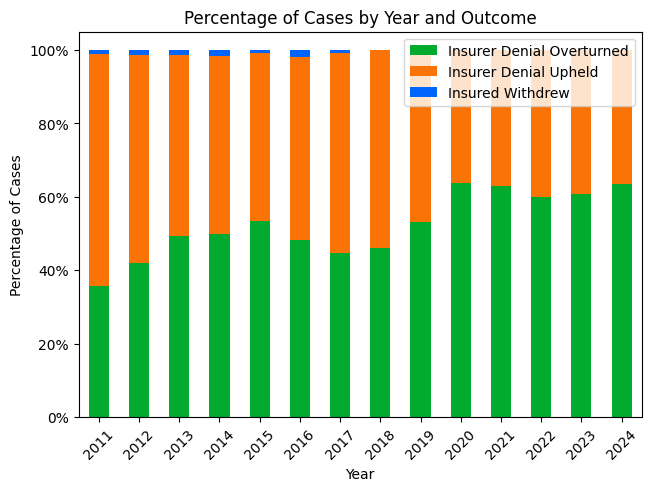

In [16]:
ax = (
    df.groupby(["year", "outcome"])
    .size()
    .unstack()
    .div(df.groupby("year").size(), axis=0)
    .rename_axis(None, axis=1)
    .plot(
        kind="bar",
        title="Percentage of Cases by Year and Outcome",
        xlabel="Year",
        ylabel="Percentage of Cases",
        rot=45,
        stacked=True,
    )
)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

The average IMRO review period and determination period are 48 and 18 days, respectively. At first glance, it seems that both periods peaked in 2016 and started decreasing until 2020 (a pandemic year), where they started increasing again.


imro_review_period      18.083507
determination_period    47.849516


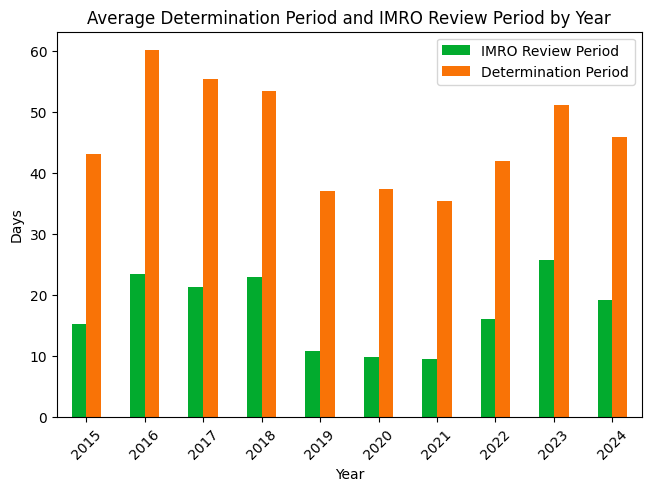

In [18]:
print(df[["imro_review_period", "determination_period"]].mean().to_string())

ax = (
    df.groupby("year")[["imro_review_period", "determination_period"]]
    .mean()
    .dropna()
    .rename(
        columns={
            "imro_review_period": "IMRO Review Period",
            "determination_period": "Determination Period",
        }
    )
    .plot(
        kind="bar",
        title="Average Determination Period and IMRO Review Period by Year",
        xlabel="Year",
        ylabel="Days",
        rot=45,
    )
)

# IMR Type


An IMR case can either be of type "Medical Necessity" or "Experimental". Around 2/3 of the cases are of type "Medical Necessity" and 1/3 are of type "Experimental". Cases of type "Medical Necessity" have a higher percentage of insurer denials being overturned (52.5%) compared to cases of type "Experimental" (45.5%).


/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_54455/1460582232.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["imr_type", "outcome"]).size().unstack().div(
/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_54455/1460582232.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("imr_type").size(), axis=0


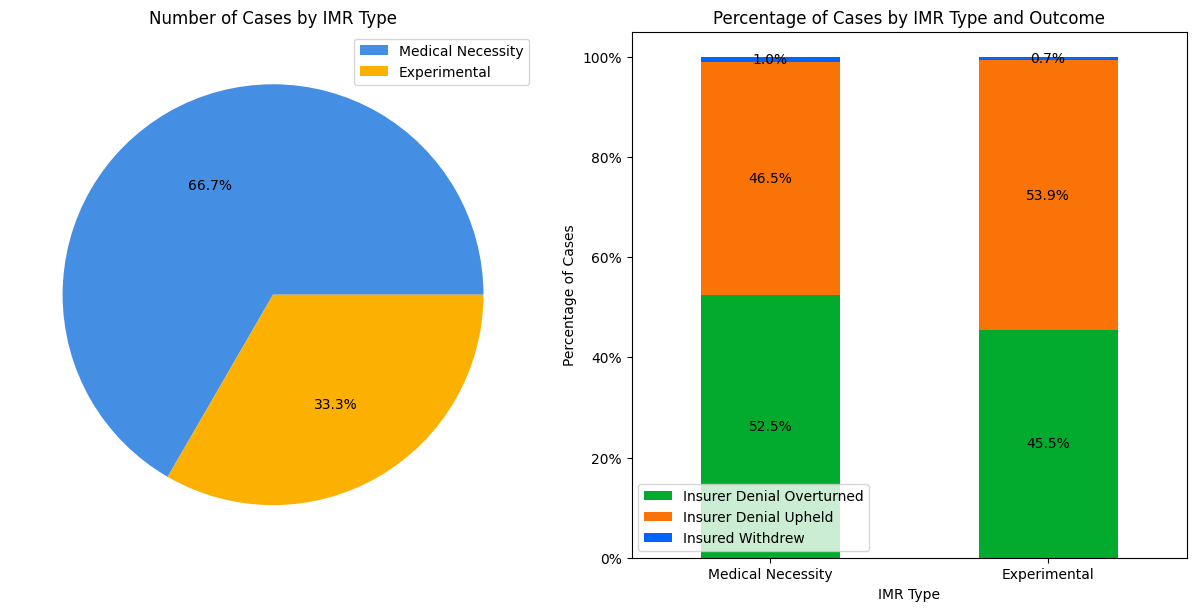

In [19]:
fig, axes = plt.subplot_mosaic([["left", "right"]], figsize=(12, 6))

df.imr_type.value_counts().plot(
    kind="pie",
    ax=axes["left"],
    title="Number of Cases by IMR Type",
    ylabel="",
    autopct="%1.1f%%",
    legend=True,
    labeldistance=None,
    colors=["xkcd:dark sky blue", "xkcd:yellow orange"],
)

df.groupby(["imr_type", "outcome"]).size().unstack().div(
    df.groupby("imr_type").size(), axis=0
).rename_axis(None, axis=1).plot.bar(
    ax=axes["right"],
    title="Percentage of Cases by IMR Type and Outcome",
    xlabel="IMR Type",
    ylabel="Percentage of Cases",
    stacked=True,
    rot=0,
)
axes["right"].yaxis.set_major_formatter(PercentFormatter(1.0))

for container in axes["right"].containers:
    if isinstance(container, BarContainer):
        axes["right"].bar_label(container=container, fmt="{:.1%}", label_type="center")

# Priority


The priority of an IMR case can be either "Standard" or "Expedited". Around 90% of the cases are of priority "Standard" and 10% are of priority "Expedited".


There is a slight edge for the "Expedited" cases in terms of the percentage of insurer denials being overturned (62.5% of "Expedited" vs 48.7% of "Standard" cases).


/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_54455/48071742.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["priority", "outcome"])
/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_54455/48071742.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .div(df.groupby("priority").size(), axis=0)


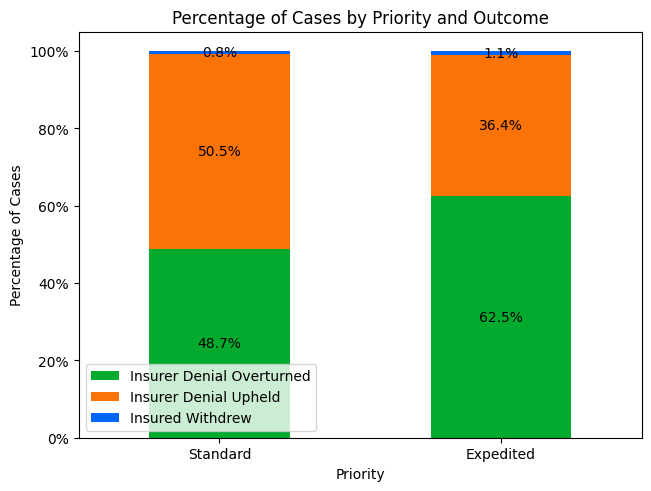

In [20]:
ax = (
    df.groupby(["priority", "outcome"])
    .size()
    .unstack()
    .div(df.groupby("priority").size(), axis=0)
    .rename_axis(None, axis=1)
    .plot(
        kind="bar",
        title="Percentage of Cases by Priority and Outcome",
        xlabel="Priority",
        ylabel="Percentage of Cases",
        stacked=True,
        rot=0,
    )
)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

for container in ax.containers:
    if isinstance(container, BarContainer):
        ax.bar_label(container=container, fmt="{:.1%}", label_type="center")

The median determination period for "Expedited" cases is 11 days, while for "Standard" cases it is 40 days. Also, the average IMRO review period for "Expedited" cases is 4 days, while for "Standard" cases it is 20 days.

There are some major outliers such as case 14-3515, which had priority of "Standard" and a determination period of 746 days.


array([<Axes: title={'center': 'determination_period'}, ylabel='priority'>,
       <Axes: title={'center': 'imro_review_period'}, ylabel='priority'>],
      dtype=object)

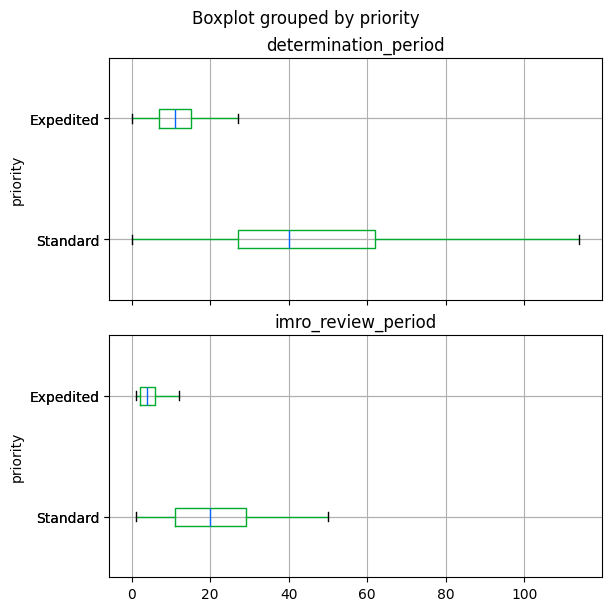

In [21]:
df.boxplot(
    by="priority",
    column=["determination_period", "imro_review_period"],
    layout=(2, 1),
    figsize=(6, 6),
    vert=False,
    showfliers=False,
)

# Diagnosis


In [12]:
print(f"There are {df.diagnosis.nunique()} unique diagnoses. The top 10 are: ")
print()
print(
    df.groupby("diagnosis")
    .size()
    .sort_values(ascending=False)
    .head(10)
    .to_string(header=False)
)

There are 22 unique diagnoses. The top 10 are: 

Mental Disorders/Psychology          1152
Musculoskeletal System/Connective     865
Cancer                                679
Nervous System/Sense Organs           371
Digestive System                      300
Circulatory/Heart                     268
Endocrine/Metabolic                   258
Genitourinary System                  156
Injuries / Poisoning                  150
Infectious Diseases                   146


/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_57653/1718914369.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("diagnosis")


Reviewing the data, by far the diagnosis with the most amount of insurer denials overturned 597 cases, followed is "Mental Disorders/Psychology" by "Musculoskeletal System/Connective" (368) and "Cancer" (314).

Percentage-wise, some notable (>100 cases) diagnoses in terms of their rate of insurer denials being overturned are Nervous System/Sense Organs (64.4%), Mental Disorders/Psychology (51.8%), and Endocrine/Metabolic (51.6%).


In [14]:
diagnosis_by_outcome = df.groupby(["diagnosis", "outcome"]).size().unstack().fillna(0)

print("The top 10 diagnoses of cases with outcomes of 'Insurer Denial Overturned' are:\n")
print(
    diagnosis_by_outcome["Insurer Denial Overturned"]
    .sort_values(ascending=False)
    .head(10).to_string(header=False)
)
print()

top_10_diagnoses = (
    (diagnosis_by_outcome["Insurer Denial Overturned"] / df.groupby("diagnosis").size())
    .sort_values(ascending=False)
    .head(10)
)


print(
    "The top 10 diagnoses likely to have an outcome of 'Insurer Denial Overturned' are:\n"
)
print(
    pd.DataFrame(
        {
            "Percentage": top_10_diagnoses,
            "Overturned Cases": diagnosis_by_outcome["Insurer Denial Overturned"].loc[
                top_10_diagnoses.index
            ],
            "Total": df.groupby("diagnosis").size().loc[top_10_diagnoses.index],
        }
    ).to_string(
        float_format="{:.1%}".format,
    )
)

The top 10 diagnoses of cases with outcomes of 'Insurer Denial Overturned' are:

Mental Disorders/Psychology          597
Musculoskeletal System/Connective    368
Cancer                               314
Nervous System/Sense Organs          239
Circulatory/Heart                    137
Endocrine/Metabolic                  133
Digestive System                     127
Infectious Diseases                   94
Genitourinary System                  77
Injuries / Poisoning                  68

The top 10 diagnoses likely to have an outcome of 'Insurer Denial Overturned' are:

                               Percentage  Overturned Cases  Total
diagnosis                                                         
Injuries                           100.0%                 1      1
Sexual/Gender Identity Issues       88.2%                30     34
Skin                                68.8%                66     96
Nervous System/Sense Organs         64.4%               239    371
Infectious Diseases   

/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_57653/2577222081.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diagnosis_by_outcome = df.groupby(["diagnosis", "outcome"]).size().unstack().fillna(0)
/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_57653/2577222081.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (diagnosis_by_outcome["Insurer Denial Overturned"] / df.groupby("diagnosis").size())
/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_57653/2577222081.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future versi

# Treatment


In [17]:
print(f"There are {df.treatment.nunique()} unique treatments. The 10 most common are:\n")
print(df.treatment.value_counts().head(10).to_string(header=False))

There are 40 unique treatments. The 10 most common are:

Diagnostic Imaging, Screening and Testing    1036
Pharmacy/Prescription Drugs                   573
Residential Treatment Center                  505
Injection / Infusion Therapy                  367
Mental Health Treatment                       275
Acute Medical Services - Inpatient            212
Cancer Treatment                              202
Durable Medical Equipment                     167
Neurosurgery                                  149
General Surgery                               139


In [19]:
subcategories_count_by_treatment = df.groupby(
    "treatment"
).treatment_subcategory.nunique()

print(f"The number of subcategories for each treatment are:\n")
print(
    subcategories_count_by_treatment.sort_values(ascending=False)
    .head(10)
    .to_string(header=False)
)
print()

print(
    f"Each treatment has an average of {subcategories_count_by_treatment.mean():.1f} subcategories."
)

The number of subcategories for each treatment are:

Diagnostic Imaging, Screening and Testing        64
Special Procedure                                50
General Surgery                                  50
Pharmacy/Prescription Drugs                      42
Durable Medical Equipment                        41
Acute Medical Services - Inpatient               35
Injection / Infusion Therapy                     35
Cancer Treatment                                 34
Electrical/ Thermal/ Radiofreq. Interventions    32
Mental Health Treatment                          31

Each treatment has an average of 20.0 subcategories.


/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_57653/2823547606.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subcategories_count_by_treatment = df.groupby(


# Age


The average age of patients is 45 years old, with a standard deviation of 18 years. The youngest patient is 0 years old and the oldest patient is 96 years old.


<Axes: >

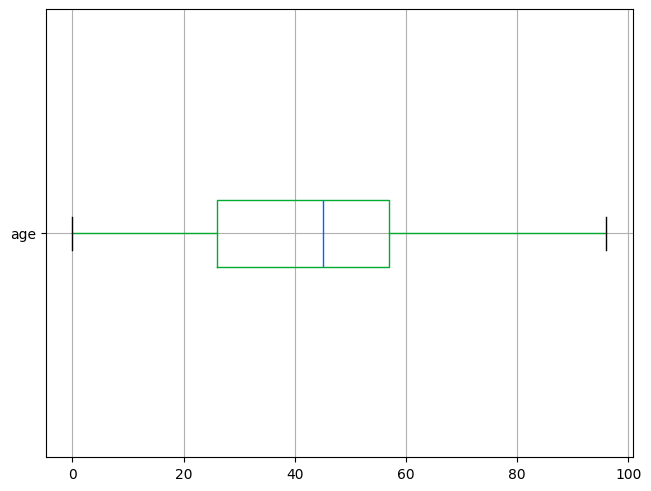

In [20]:
df.boxplot(column="age", vert=False)

<Axes: title={'center': 'Distribution of ages'}, xlabel='Age (in years)', ylabel='Frequency'>

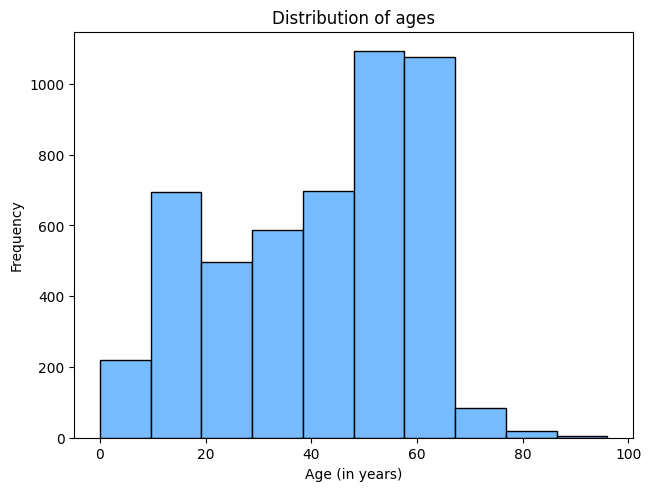

In [21]:
df.age.plot.hist(
    bins=10,
    xlabel="Age (in years)",
    title="Distribution of ages",
    edgecolor="black",
    color="xkcd:sky blue",
)

# Statutory Criteria


# Primary Language
